# Introduction

Importo il necessario


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import operator
import random
import re
import csv
import numpy as np
import pandas as pd
import seaborn as sn
import os.path
import _pickle as cPickle
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.feature_extraction as fe
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import xgboost as xgb
plt.style.use('seaborn')

# Document retrieval

Vado a recuperare i file che mi servono per la fase di training/testing. Il ciclo `for` serve per ottenere la corrispondenza file-linguaggio. I linguaggi presenti nell'array `accepted` sono le classi del classificatore. `max_num_of_files` è il numero di file accettati per singolo linguaggio. 

Num    3213
dtype: int64


,Num
Hello-world-Text,464
Arrays,404
Call-a-function,259
Loops-For,251
Palindrome-detection,244
Loops-While,236
Even-or-odd,201
Tokenize-a-string,198
Roman-numerals-Encode,181
Sort-an-integer-array,167


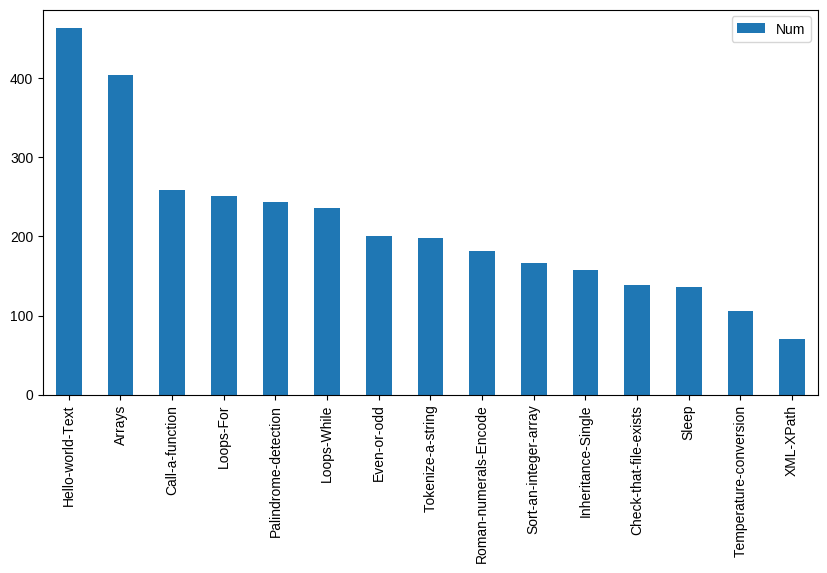

In [2]:
plt.style.use('default')

def check_open_utf8(f): #apre i file e controlla che siano validi 
    try:
        open(f, 'r').read()
        return True
    except:
        return False

file_num = {}
file_list = []
file_ext = []
#da cambiare con i task (fare un file tipo list_task.py in cui mi creo un dataset in cui in ogni riga c'è il percorso di ogni file e il task a cui si riferisce)
#accepted = ["Averages-Pythagorean-means", "Fibonacci-sequence","Greatest-element-of-a-list", "Inheritance-Single", "Anagrams-Deranged-anagrams",  "Sort-an-integer-array", "A+B", \
#        "Loops-While", "Hello-world-Text", "Input-loop", "Temperature-conversion", "Palindrome-detection", "Tokenize-a-string", "Sum-digits-of-an-integer", "Sorting-algorithms-Quicksort",  \
#        "Sorting-algorithms-Merge-sort", "Sorting-algorithms-Bubble-sort", "Substring-Top-and-tail", "Roman-numerals-Encode", "Even-or-odd"]

#accepted = ["Fibonacci-sequence", "Sort-an-integer-array", "A+B", "Loops-While", "Hello-world-Text", "Input-loop", "Temperature-conversion", \
#       "Palindrome-detection", "Tokenize-a-string", "Sorting-algorithms-Quicksort", "Substring-Top-and-tail", "Roman-numerals-Encode", "Even-or-odd"] 

accepted = ["Loops-For", "Sort-an-integer-array", "Inheritance-Single", "Loops-While", "Hello-world-Text", "Temperature-conversion", \
        "Palindrome-detection", "Tokenize-a-string", "Roman-numerals-Encode", "Even-or-odd", "Arrays", "XML-XPath", "Sleep", "Call-a-function", "Check-that-file-exists"] 

max_num_of_files = 6000

with open('listing.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if len(row) > 1:
            if row[0] and row[1]:
                if os.path.isfile(row[0]):
                    if row[1] in accepted:
                        add = False
                        if check_open_utf8(row[0]):
                            if row[1] in file_num:
                                if file_num[row[1]] < max_num_of_files:
                                    add = True
                                    file_num[row[1]] += 1
                            else:
                                add = True
                                file_num[row[1]] = 1
                            if add:
                                file_list.append(row[0])
                                file_ext.append(row[1])

# Mostro in output le informazioni sui file acquisiti
data = pd.DataFrame.from_dict(file_num, orient='index', columns=["Num"]) #grafici
data = data.sort_values(by=["Num"], ascending=False)
# Disegno un grafico che le mostri
pie_chart = data.plot.bar(y='Num', figsize=(10,5))
pie_chart.get_figure()
plt.style.use('seaborn')
print(data.sum(axis = 0, skipna = True))
data

# NLP

La funzione `preprocess` prende in input la lista contenente il nome dei file accettati nella sezione precedente, legge il contenuto dei documenti e restituisce una serie (di *Pandas*) con il contenuto dei file opportunamente modificato. Il primo e il secondo replace rimuovono tutte le stringhe del tipo `xxxx`, `aaaaa`, `b`, `c`. I successivi replace vanno a sostituire con delle keyword le porzioni di stringa contenenti commenti. Infatti, non mi interessa sapere il contenuto di un commento, è molto più interessante sapere il tipo di commento (e.g. `//.*?\n` diventa `ccommentstyle` nei linguaggi C-like o `#.*?\n` diventa `pycommentstyle` in quelli funzioniali/Python-like).



La funzione `tokenizer`, invece, tramite `re.findall()` cerca tutte le occorrenze che coincidono con la regex `token_pattern`. Infine, `tokenizer` cerca tra i token restituiti da `re.findall()`quelli che sono numerici e li rimpiazza con un token predefinito `XXXtokenNumberXXX`.

A questo punto vengono costruiti training e test set. Il `TfidfVectorizer` ha come tokenizer la funzione `tokenizer` (di cui si è discusso prima), un numero di feature massimo di 4000 e gli ngram spaziano da 1 a 3. Tramite il Dataframe si possono visualizzare le 4000 feature, riportate tramite `PCA` anche nel grafico.

,\t,\t \t,\t !,\t #,\t $,\t %,\t .,\t /*,\t //,\t ;,...,} ],} class,} else,} end,} if,} public,} return,} {,} },~
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.031449
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081053,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


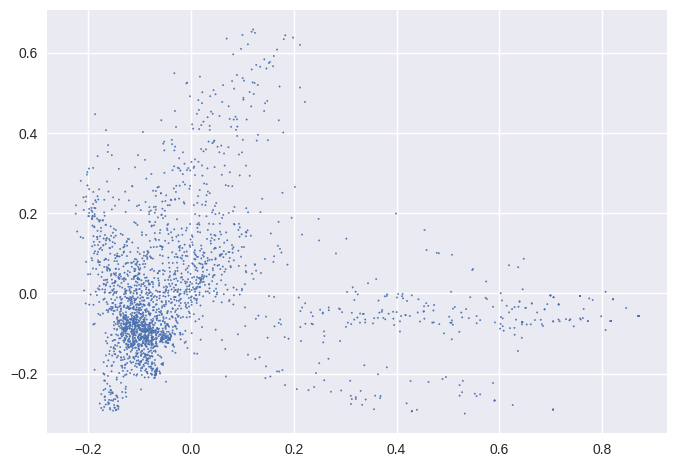

In [3]:
def preprocess(x):  #apre tutti i file tramite list(map(open(x))) e li restituisce tramite frame di pandas 
    ls_file = list(map(lambda v: open(v, 'r').read(), x))
    return pd.Series(ls_file) #restituisce un array in cui sono contenuti tutti i file aperti 

def tokenizer(txt): #prende il documento aperto e restituisce una lista di token appartententi al documento 
    token_pattern = r"""([0-9]+|[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[\t\(\),;\{\}\[\]"'`])"""
    tokens = re.findall(token_pattern, txt)
    #tokens = list(map(check_num, tokens))
    return tokens

X_train, X_test, y_train, y_test = ms.train_test_split(file_list, file_ext, test_size=0.25) #divido il dataset in training e testing 
transformer = FunctionTransformer(preprocess) #esegue la funzione preprocess su tutto l'input. Trasforma i file da percorso a file vero e proprio 
tfidf_vectorizer = fe.text.TfidfVectorizer(ngram_range=range(1, 3), tokenizer=tokenizer, max_features=2500) #calcola la vettorizzazione tfidf
#count_vectorizer = fe.text.CountVectorizer(ngram_range=range(1, 3), tokenizer=tokenizer, max_features=2500) 
# Visualization
X = tfidf_vectorizer.fit_transform(transformer.fit_transform(X_train)) #esegue la vettorizzazione tfidf su X_train


lb = LabelBinarizer() 
lb.fit(accepted) 
        
pca = PCA(n_components=2) #roba matematica strana per grafici fighi 
two_dim = pca.fit_transform(X.todense())
s = [1 for n in range(len(two_dim[:, 0]))]
plt.scatter(two_dim[:, 0], two_dim[:, 1], s=s)
plt
pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())

# ML Parameters

Modelli, e relativi parametri, che vengono testati 

In [4]:
result = [] 

y_train_enc = lb.transform(y_train) #trasformo tutte le y nel formato binarizzato

input_dim = X.toarray().shape[1] #dimensione input = numero di parole nella vettorizzazione 
output_dim = len(y_train_enc[0]) #dimensione output = lunghezza della lista binarizzata (20 se i task sono 20)
dim = int(2/3 * input_dim + output_dim) #dimensione dei layer della rete neurale 

def baseline_model(): #serve a costurire il modello
    # create model
    model = Sequential() #tipo di rete neurale. Sequenziale = modello classico in cui i layer sono uno dopo l'altro
    model.add(Dense(dim, input_dim=input_dim, activation='relu')) 
    model.add(Dropout(0.2, input_shape=(dim,))) #layer di dropout. ogni valore ha probabilità 0.2 di essere annullato
    model.add(Dense(dim, activation='relu')) #layer dim
    model.add(Dense(output_dim, activation='softmax')) #come funzione di attivazione ha la funzione softmax, che fa la somma di tutti i risultati finali e poi li divide per la somma
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) #model compile = compila il modello. 
    return model

ann_model = KerasClassifier(build_fn=baseline_model) #wrapper di keras per costruire il modello. 
parameters = [
    {
        'clf':[ 
            Pipeline(
                [
                    ('transformer', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
                    ('clf', ann_model)
                ]
            )
        ],
        'name': 'ANN',
        'clf__clf__epochs': [10,50],
        'clf__clf__batch_size': [32,64,128], 
        'clf__clf__verbose': [0]
    },
    {
        'clf': [RandomForestClassifier(n_jobs=-1)],
        'name': 'RandomForestClassifier',
        "clf__n_estimators": [400, 500, 700],
        "clf__criterion": ["gini"],
        "clf__min_samples_split": [3, 4],
        "clf__max_features": ["sqrt", "log2"]
    },
    {
        'clf': [SVC()],
        'name': 'SVC',
        'clf__C': [100,500, 1000, 10e5],
        'clf__kernel': ['rbf'],
        'clf__class_weight': ['balanced'],
        'clf__probability': [True]
    }
]

# Fitting

Tramite `CV`, viene fatto il training dei vari modelli e viene stampato un valore di Accuracy. I risultati vengono memorizzati in **result** per una comparazione successiva.

Di seguito una matrice di confusione per visualizzare i risultati. Questa matrice fa riferimento a SVM. I valori sono normalizzati. 

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END clf__C=100, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True; total time=   7.7s
[CV] END clf__C=100, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True; total time=   7.3s
[CV] END clf__C=100, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True; total time=   7.2s
[CV] END clf__C=500, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True; total time=   7.4s
[CV] END clf__C=500, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True; total time=   7.2s
[CV] END clf__C=500, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True; total time=   7.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True; total time=   7.4s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True; total time=   7.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__kernel=rbf, clf__pr

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

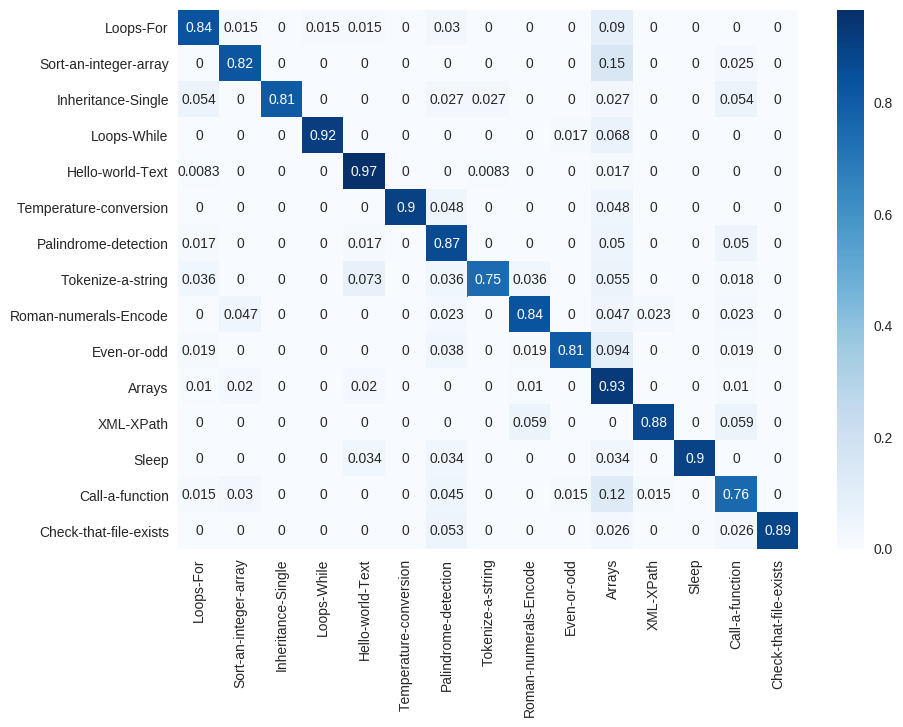

In [5]:
clf = parameters[2]['clf'][0] #recupero rete neurale
name = parameters[2]['name'] #recupero il nome 
parameters[2].pop('clf') #tolgo dalla lista clf 
parameters[2].pop('name') #tolgo dalla lista il nome 

pipe_RF = Pipeline([   
    ('preprocessing', transformer),
    ('vectorizer', tfidf_vectorizer),
    ('clf', clf)]
)
grid = GridSearchCV(pipe_RF, param_grid=parameters[2], cv=3, verbose=2) #prova sulla pipeline i parametri definiti prima

grid.fit(X_train, y_train) #il fit manda in esecuzione parametri e valori
# Evaluation
print(f' - {name} Accuracy: {grid.score(X_test, y_test)}') #stampa il risultato e l'appendo alla lista 

# storing result
result.append({
    'grid': grid,
    'name': name,
    'classifier': grid.best_estimator_,
    'best score': grid.best_score_,
    'best params': grid.best_params_,
    'cv': grid.cv
    })

SVC = result[-1] #prendo l'ultimo valore della lista 

y_pred = SVC["grid"].best_estimator_.predict(X_test)

array = confusion_matrix(y_test, y_pred, normalize='true', labels=accepted)
df_cm = pd.DataFrame(array, index =accepted,
              columns =accepted)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.yticks(rotation=0)
plt

Questa matrice fa riferimento all' ANN. I valori sono normalizzati.

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
[CV] END clf__clf__batch_size=32, clf__clf__epochs=10, clf__clf__verbose=0; total time=11.3min
[CV] END clf__clf__batch_size=32, clf__clf__epochs=10, clf__clf__verbose=0; total time=11.3min
[CV] END clf__clf__batch_size=32, clf__clf__epochs=10, clf__clf__verbose=0; total time=11.3min
[CV] END clf__clf__batch_size=32, clf__clf__epochs=50, clf__clf__verbose=0; total time=23.3min
[CV] END clf__clf__batch_size=32, clf__clf__epochs=50, clf__clf__verbose=0; total time=23.3min
[CV] END clf__clf__batch_size=32, clf__clf__epochs=50, clf__clf__verbose=0; total time=23.4min
[CV] END clf__clf__batch_size=64, clf__clf__epochs=10, clf__clf__verbose=0; total time= 9.9min
[CV] END clf__clf__batch_size=64, clf__c

<module 'matplotlib.pyplot' from '/home/pennino/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

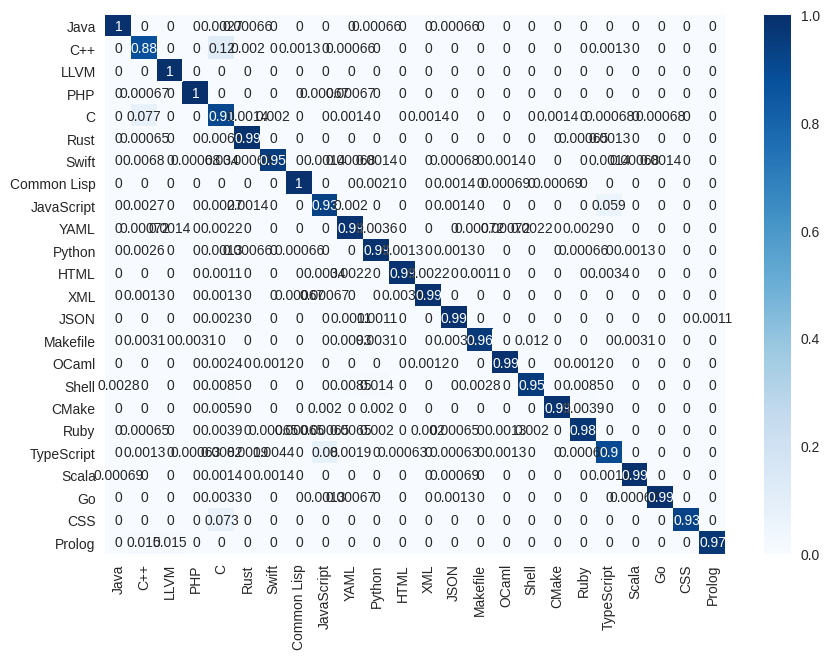

In [ ]:
clf = parameters[0]['clf'][0]
name = parameters[0]['name']
parameters[0].pop('clf')
parameters[0].pop('name')

pipe_RF = Pipeline([
    ('preprocessing', transformer),
    ('vectorizer', tfidf_vectorizer),
    ('clf', clf)]
)
grid = GridSearchCV(pipe_RF, param_grid=parameters[0], cv=3, verbose=2)

grid.fit(X_train, lb.transform(y_train))
# Evaluation
print(f' - {name} Accuracy: {grid.score(X_test, lb.transform(y_test))}')

# storing result
result.append({
    'grid': grid,
    'name': name,
    'classifier': grid.best_estimator_,
    'best score': grid.best_score_,
    'best params': grid.best_params_,
    'cv': grid.cv
    })

ANN = result[-1]

y_pred = ANN["grid"].best_estimator_.predict(X_test)

def map_to_array(x): 
    final = [0] * len(accepted)
    final[x] = 1
    return final
    
y_pred = np.array(list(map(map_to_array, list(y_pred))))
conf_matrix = confusion_matrix(y_test, lb.inverse_transform(y_pred), normalize='true', labels=accepted)
df_cm = pd.DataFrame(conf_matrix, index=accepted,
                     columns=accepted)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt

Questa matrice fa riferimento al miglior modello Random Forest.

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=400; total time=10.0min
[CV] END clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=400; total time=10.1min
[CV] END clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=400; total time=10.1min
[CV] END clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=500; total time=10.5min
[CV] END clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=500; total time=10.5min
[CV] END clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=500; total time=10.5min
[CV] END clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=700; total time=11.4min
[CV] END clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__

<module 'matplotlib.pyplot' from '/home/pennino/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

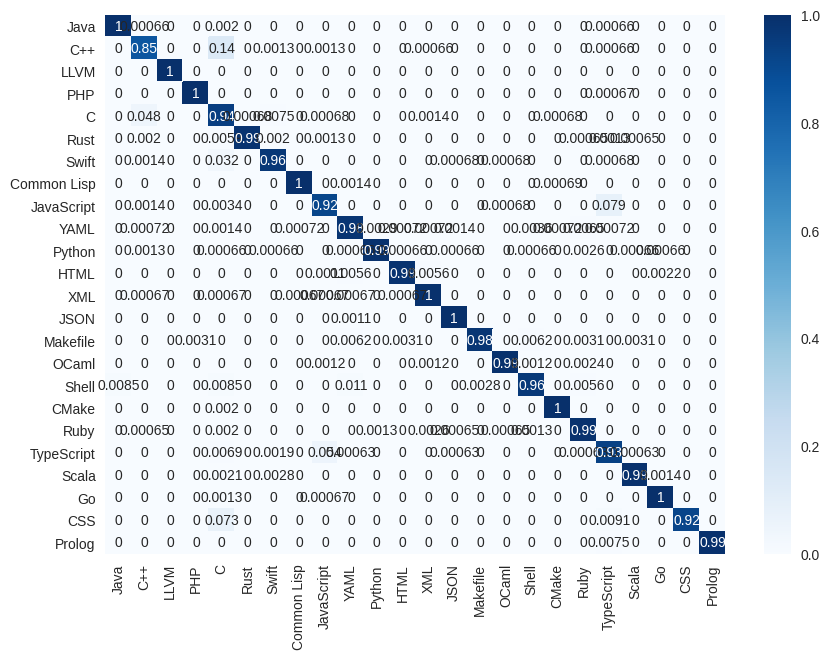

In [ ]:
clf = parameters[1]['clf'][0]
name = parameters[1]['name']
parameters[1].pop('clf')
parameters[1].pop('name')

pipe_RF = Pipeline([
    ('preprocessing', transformer),
    ('vectorizer', tfidf_vectorizer),
    ('clf', clf)]
)
grid = GridSearchCV(pipe_RF, param_grid=parameters[1], cv=3, verbose=2)

grid.fit(X_train, y_train)
# Evaluation
print(f' - {name} Accuracy: {grid.score(X_test, y_test)}')

# storing result
result.append({
    'grid': grid,
    'name': name,
    'classifier': grid.best_estimator_,
    'best score': grid.best_score_,
    'best params': grid.best_params_,
    'cv': grid.cv
    })

RandomForestP = result[-1]

y_pred = RandomForestP["grid"].best_estimator_.predict(X_test)

array = confusion_matrix(y_test, y_pred, normalize='true', labels=accepted)
df_cm = pd.DataFrame(array, index =accepted,
              columns =accepted)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.yticks(rotation=0)
plt

Per Random Forest mostro le 20 stringhe con *feature importances* più alto:

<AxesSubplot:>

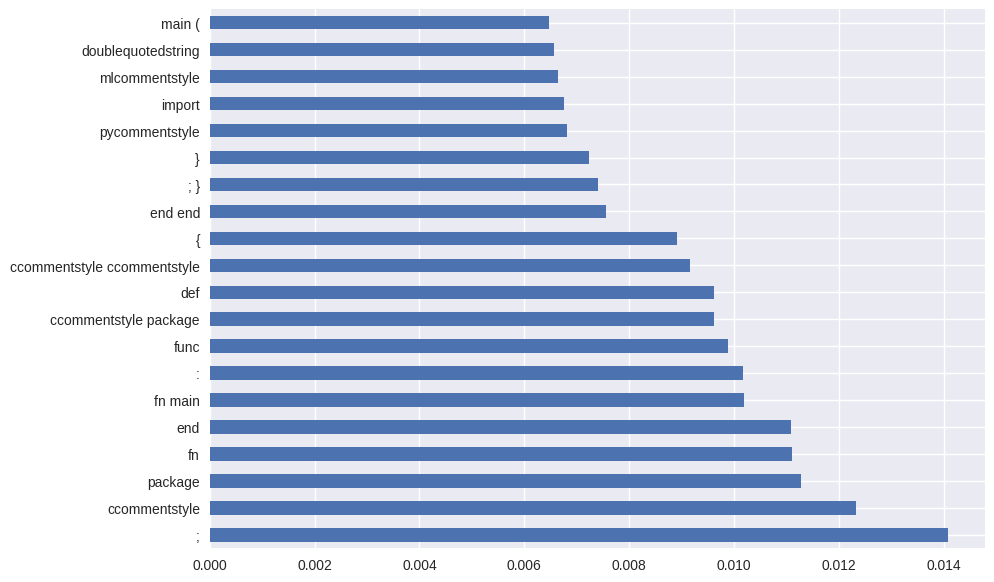

In [ ]:
plt.style.use('seaborn') #far vedere i token (parole o coppie di parole) che sceglie come più importanti per il random forest
        
importances = RandomForestP["grid"].best_estimator_["clf"].feature_importances_

plt.figure(figsize = (10,7))

(pd.Series(importances, index=tfidf_vectorizer.get_feature_names())
   .nlargest(20)
   .plot(kind='barh'))  

# Comparison


Comparazione tra i migliori:

In [ ]:
result = sorted(result, key=operator.itemgetter('best score'), reverse=True) #confronto tra i parametri e viene mostrato il migliore di ogni modello e la classifica tra il migliore dei 3 modelli 

pd.DataFrame.from_dict([{
      'name':v['name'],
      'score': v['best score'],
      'param': v['best params']
     } for v in result])

,name,score,param
0,RandomForestClassifier,0.971161,"{'clf__criterion': 'gini', 'clf__max_features'..."
1,ANN,0.965982,"{'clf__clf__batch_size': 64, 'clf__clf__epochs..."
2,SVC,0.965946,"{'clf__C': 100, 'clf__class_weight': 'balanced..."


Quelli che risultano essere i migliori parametri:

In [ ]:
result[0]['best params']

{'clf__criterion': 'gini',
 'clf__max_features': 'sqrt',
 'clf__min_samples_split': 3,
 'clf__n_estimators': 700}